##SMS Spam dataset predicts spam/ham. LIME highlights spam words.
Tasks:
1. Load dataset
2. Train Logistic Regression
3. Apply LIME Text
4. Highlight words
Deliverables:
 Code
 Outputs
 Report


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=122322ad612a3d4edae04cf7c0f39f2da3fe5bfbb10743478026b45c369653b1
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from pathlib import Path


In [ ]:
data_path = Path("/content/SMSSpamCollection")
df = pd.read_csv(data_path, sep='\t', header=None, names=['label', 'text'])


In [ ]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression())
pipeline.fit(X_train, y_train)

print("Training Accuracy:", pipeline.score(X_train, y_train))
print("Test Accuracy:", pipeline.score(X_test, y_test))


Training Accuracy: 0.9744222571236257
Test Accuracy: 0.9748878923766816


In [ ]:
class_names = ['ham', 'spam']
explainer = LimeTextExplainer(class_names=class_names)

sample_index = 10
sample_text = X_test.iloc[sample_index]
true_label = y_test.iloc[sample_index]

print(sample_text)
print("Actual Label:", true_label)

exp = explainer.explain_instance(
    sample_text,
    pipeline.predict_proba,
    num_features=6
)


Lol grr my mom is taking forever with my prescription. Pharmacy is like 2 minutes away. Ugh.
Actual Label: ham


In [ ]:
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

output_file = output_dir / "lime_explanation.html"
exp.save_to_file(str(output_file))

print(f"LIME explanation saved to: {output_file.resolve()}")


LIME explanation saved to: /content/outputs/lime_explanation.html


##Airline dataset predicts satisfaction. LIME explains service-related features.
Tasks:
1. Load dataset
2. Train Gradient Boosting
3. Apply LIME
4. Interpret contributions
Deliverables:
 Code
 Outputs
 Report

Dataset preview:
   Gender      Customer Type   Type of Travel     Class  Age  Flight Distance  \
0  Female     Loyal Customer  Personal Travel       Eco   18              950   
1    Male  Disloyal Customer  Business travel  Eco Plus   53              786   
2  Female  Disloyal Customer  Personal Travel  Business   53             1570   
3  Female     Loyal Customer  Personal Travel  Business   33               80   
4    Male     Loyal Customer  Personal Travel       Eco   45             1536   

   Departure Delay in Minutes  Arrival Delay in Minutes  \
0                          12                         2   
1                           5                         1   
2                           3                         3   
3                           9                         0   
4                          18                        13   

   Inflight wifi service  Ease of Online booking  ...  Online boarding  \
0                      2                       5  ...              

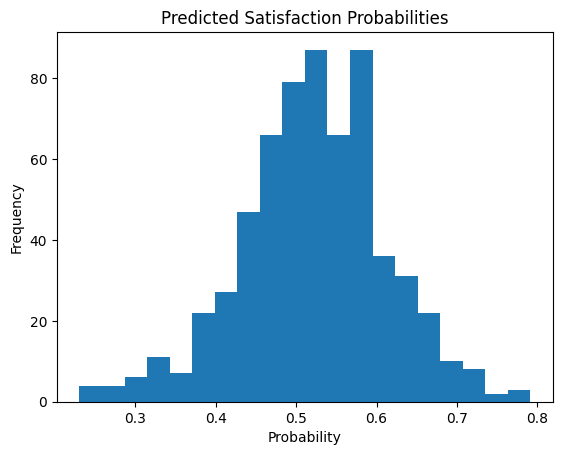

In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# -----------------------------
# File paths
# -----------------------------
DATASET_PATH = "/content/airline_satisfaction.csv"
METRICS_PATH = "/content/metrics_summary.csv"
LOCAL_EXPLAIN_PATH = "/content/local_explanations.csv"
REPORT_PDF_PATH = "/content/metrics_summary.csv"

# -----------------------------
# 1) Load dataset
# -----------------------------
df = pd.read_csv(DATASET_PATH)
print("Dataset preview:")
print(df.head())

# -----------------------------
# 2) Train Gradient Boosting
# -----------------------------
X = df.drop("Satisfaction", axis=1)
y = df["Satisfaction"]

cat_cols = ["Gender", "Customer Type", "Type of Travel", "Class"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

gb_model = GradientBoostingClassifier(random_state=42)
pipeline = Pipeline([("pre", preprocessor), ("clf", gb_model)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:,1]

# Save metrics
metrics_df = pd.DataFrame([{
    "accuracy": accuracy_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob)
}])
metrics_df.to_csv(METRICS_PATH, index=False)
print("\nMetrics saved to:", METRICS_PATH)

# Print metrics
print("\nModel Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -----------------------------
# 3) LIME-style explanations
# -----------------------------
def lime_explanation(instance, n_samples=500):
    Xp = pd.concat([instance]*n_samples, ignore_index=True)
    # numeric jitter
    for col in num_cols:
        std = X[col].std()
        Xp[col] += np.random.normal(0, 0.5*std, size=n_samples)
    # categorical flips
    for col in cat_cols:
        mask = np.random.rand(n_samples) < 0.1
        choices = X[col].unique()
        Xp.loc[mask, col] = np.random.choice(choices, mask.sum())
    # predict
    yhat = pipeline.predict_proba(Xp)[:,1]
    # weighted Ridge
    X_trans = pipeline.named_steps["pre"].transform(Xp)
    ridge = Ridge()
    ridge.fit(X_trans, yhat)
    coefs = ridge.coef_
    feat_names = []
    try:
        ohe = pipeline.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
        cat_feat_names = list(ohe.get_feature_names_out(cat_cols))
        feat_names = num_cols + cat_feat_names
    except:
        feat_names = range(len(coefs))
    contribs = pd.DataFrame({"feature": feat_names, "contribution": coefs})
    return contribs

# Explain 3 test instances
instances = {
    "Most-likely Satisfied": X_test.iloc[[np.argmax(y_prob)]],
    "Most-likely Dissatisfied": X_test.iloc[[np.argmin(y_prob)]],
    "Random Passenger": X_test.sample(1, random_state=42)
}

all_explanations = []
for label, instance in instances.items():
    contribs = lime_explanation(instance)
    contribs["instance"] = label
    all_explanations.append(contribs)

all_explanations_df = pd.concat(all_explanations, ignore_index=True)
all_explanations_df.to_csv(LOCAL_EXPLAIN_PATH, index=False)
print("\nLIME-style explanations saved to:", LOCAL_EXPLAIN_PATH)

# -----------------------------
# 4) Optional: visualize probability histogram
# -----------------------------
plt.figure()
plt.hist(y_prob, bins=20)
plt.title("Predicted Satisfaction Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()
